In [1]:
import pdfplumber


In [144]:
url = "./Reglamento-de-Transito-CDMX.pdf"

table_settings = {
    "vertical_strategy": "lines",
    "horizontal_strategy": "lines",
    "snap_x_tolerance": 10,
    #"intersection_x_tolerance": 15,
}

beta = {}


In [145]:

with pdfplumber.open(url) as pdf:
    alpha = [page.extract_text(keep_blank_chars=True) for page in pdf.pages]
    for page in pdf.pages:
        table = page.find_table()
        if table is not None:
            beta[page.page_number] = (page.crop(table.bbox),page.extract_table(table_settings))
            

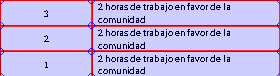

In [121]:
x[68].to_image().debug_tablefinder(table_settings)

In [148]:
print(alpha[0])

 
PUBLICADO EN LA GACETA OFICIAL DEL DISTRITO FEDERAL 
EL 17 DE AGOSTO DE 2015 
 
TEXTO VIGENTE 
 
Última reforma publicada en la G.O. CDMX  
el 10 de agosto de 2023 
 
MIGUEL ÁNGEL MANCERA ESPINOSA, Jefe de Gobierno del Distrito Federal, con fundamento en los 
artículos 122, Apartado C, Base Segunda, fracción II, inciso b), de la Constitución Política de los Estados 
Unidos Mexicanos; 8º, fracción II, 67, fracción II y 90 del Estatuto de Gobierno del Distrito Federal; 12, 14 y 
15 fracción I, IV, VIII, IX, X, 23, 26, 30 y 31  de la Ley Orgánica de la Administración Pública del Distrito Federal; 
y 68, 198, 251 y 252 de la Ley de Movilidad del Distrito Federal; artículo 2, fracción III de la Ley de Seguridad 
Pública del Distrito Federal, artículos 3°, 26 y 34 de la Ley Orgánica de la Secretaría de Seguridad Pública 
del Distrito Federal, he tenido a bien expedir el siguiente: 
 
REGLAMENTO DE TRÁNSITO DE LA CIUDAD DE MÉXICO 
 
TÍTULO PRIMERO 
DISPOSICIONES GENERALES 
 
CAPÍTULO I 
DEL

In [151]:
beta.keys()

dict_keys([10, 11, 67, 68, 132])

In [185]:

for i, outer_list in enumerate(beta[10][1]):
    for j, inner_list in enumerate(outer_list):
        beta[10][1][i][j] = inner_list.replace("\n", " ")
        
for i, outer_list in enumerate(beta[11][1]):
    for j, inner_list in enumerate(outer_list):
        beta[11][1][i][j] = inner_list.replace("\n", " ")
        
for i, outer_list in enumerate(beta[67][1]):
    for j, inner_list in enumerate(outer_list):
        beta[67][1][i][j] = inner_list.replace("\n", " ")

for i, outer_list in enumerate(beta[68][1]):
    for j, inner_list in enumerate(outer_list):
        beta[68][1][i][j] = inner_list.replace("\n", " ")

for i, outer_list in enumerate(beta[132][1]):
    for j, inner_list in enumerate(outer_list):
        beta[132][1][i][j] = inner_list.replace("\n", " ")

In [182]:
beta[10][1]

[['Tipo de vehículo',
  'Sanción con multa equivalente en veces la Unidad de Medida y Actualización vigente',
  'Sanción mínima',
  'Sanción media',
  'Sanción máxima',
  'Sanción con puntos de penalización en licencia para conducir'],
 ['Conductores de vehículos',
  '10 a 20 veces',
  '10 veces',
  '15 veces',
  '20 veces',
  '3 puntos']]

In [154]:
import pandas as pd

In [186]:
df = pd.DataFrame(beta[10][1][1:],columns=beta[10][1][0])
df_2 = pd.DataFrame(beta[11][1][0:],columns=beta[10][1][0])
df_3 = pd.DataFrame(beta[67][1][1:],columns=beta[67][1][0])
df_4 = pd.DataFrame(beta[68][1][0:],columns=beta[67][1][0])
df_5 = pd.DataFrame(beta[132][1][1:],columns=beta[132][1][0])

In [187]:
df_2

,Tipo de vehículo,Sanción con multa equivalente en veces la Unidad de Medida y Actualización vigente,Sanción mínima,Sanción media,Sanción máxima,Sanción con puntos de penalización en licencia para conducir
0,de uso particular.,,,,,
1,Conductores de vehículos de transporte de carga.,40 a 60 veces,40 veces,50 veces,60 veces,3 puntos
2,Conductores de vehículos de transporte público...,60 a 80 veces,60 veces,70 veces,80 veces,3 puntos


In [188]:
df_3

,Puntos restantes,Sanción
0,9 o primera infracción,Amonestación
1,8 o segunda infracción,Curso en línea básico
2,7,Curso en línea intermedio
3,6,Curso en línea avanzado
4,5,Taller de sensibilización presencial
5,4,2 horas de trabajo en favor de la comunidad


In [189]:
df_4

,Puntos restantes,Sanción
0,3,2 horas de trabajo en favor de la comunidad
1,2,2 horas de trabajo en favor de la comunidad
2,1,2 horas de trabajo en favor de la comunidad


In [190]:
df_5

,Tipo de asiento,Ubicación,Grupo,Rango de peso,Rango aproximado de edad
0,,De espaldas,0,0 – 10 kg,Nacimiento y hasta los 6 - 9 meses
1,,De espaldas,0+,0 – 13 kg,Nacimiento y hasta los 12 - 15 meses
2,,De frente,1,9 – 18 kg,9 meses – 4 años
3,,De frente,2,15 – 25 kg,4 – 6 años
4,,Asiento elevador,3,22 – 36 kg,6 – 11 años


In [195]:
df_12 = pd.concat([df,df_2],axis=0,ignore_index=True)
df_34 = pd.concat([df_3,df_4],axis=0,ignore_index=True)

In [194]:
df_12

,Tipo de vehículo,Sanción con multa equivalente en veces la Unidad de Medida y Actualización vigente,Sanción mínima,Sanción media,Sanción máxima,Sanción con puntos de penalización en licencia para conducir
0,Conductores de vehículos,10 a 20 veces,10 veces,15 veces,20 veces,3 puntos
1,de uso particular.,,,,,
2,Conductores de vehículos de transporte de carga.,40 a 60 veces,40 veces,50 veces,60 veces,3 puntos
3,Conductores de vehículos de transporte público...,60 a 80 veces,60 veces,70 veces,80 veces,3 puntos


In [196]:
df_34

,Puntos restantes,Sanción
0,9 o primera infracción,Amonestación
1,8 o segunda infracción,Curso en línea básico
2,7,Curso en línea intermedio
3,6,Curso en línea avanzado
4,5,Taller de sensibilización presencial
5,4,2 horas de trabajo en favor de la comunidad
6,3,2 horas de trabajo en favor de la comunidad
7,2,2 horas de trabajo en favor de la comunidad
8,1,2 horas de trabajo en favor de la comunidad


In [198]:
print(df_34.to_string())

         Puntos restantes                                      Sanción
0  9 o primera infracción                                 Amonestación
1  8 o segunda infracción                        Curso en línea básico
2                       7                    Curso en línea intermedio
3                       6                      Curso en línea avanzado
4                       5         Taller de sensibilización presencial
5                       4  2 horas de trabajo en favor de la comunidad
6                       3  2 horas de trabajo en favor de la comunidad
7                       2  2 horas de trabajo en favor de la comunidad
8                       1  2 horas de trabajo en favor de la comunidad


In [201]:
print(alpha[9])

 
 
III.  Prioridad de uso del arroyo vehicular, cuando: 
 
a)  No existan aceras en la vía; en caso de existir acotamiento o vías ciclistas, los peatones podrán 
circular del lado derecho de éstas; a falta de estas opciones transitarán por el extremo de la 
vía y en sentido contrario al flujo vehicular; 
 
b)  Las aceras estén impedidas para el libre tránsito peatonal por consecuencia de obras públicas 
o privadas, eventos que interfieran de forma temporal la circulación o cuando el flujo de 
peatones supere la capacidad de la acera; la autoridad se asegurará de la implementación de 
espacios  seguros  para  los  transeúntes;  mismas  que  estarán  delimitadas,  confinadas  y 
señalizadas, conforme a la legislación aplicable y por parte de quien genere las anomalías en 
la vía; 
 
c)  Transiten en comitivas organizadas, procesiones o filas escolares, debiendo circular en el 
sentido de la vía; 
 
d)  Remolquen algún objeto que impida la libre circulación de los demás peatones sobre la

In [205]:
alpha[9]

' \n \nIII.  Prioridad de uso del arroyo vehicular, cuando: \n \na)  No existan aceras en la vía; en caso de existir acotamiento o vías ciclistas, los peatones podrán \ncircular del lado derecho de éstas; a falta de estas opciones transitarán por el extremo de la \nvía y en sentido contrario al flujo vehicular; \n \nb)  Las aceras estén impedidas para el libre tránsito peatonal por consecuencia de obras públicas \no privadas, eventos que interfieran de forma temporal la circulación o cuando el flujo de \npeatones supere la capacidad de la acera; la autoridad se asegurará de la implementación de \nespacios  seguros  para  los  transeúntes;  mismas  que  estarán  delimitadas,  confinadas  y \nseñalizadas, conforme a la legislación aplicable y por parte de quien genere las anomalías en \nla vía; \n \nc)  Transiten en comitivas organizadas, procesiones o filas escolares, debiendo circular en el \nsentido de la vía; \n \nd)  Remolquen algún objeto que impida la libre circulación de los demá

In [ ]:
def rempve_last_paragraph(text):
    para = text.split("\n\n")

In [208]:
alpha[9].split(" \n \n")

['',
 'III.  Prioridad de uso del arroyo vehicular, cuando:',
 'a)  No existan aceras en la vía; en caso de existir acotamiento o vías ciclistas, los peatones podrán \ncircular del lado derecho de éstas; a falta de estas opciones transitarán por el extremo de la \nvía y en sentido contrario al flujo vehicular;',
 'b)  Las aceras estén impedidas para el libre tránsito peatonal por consecuencia de obras públicas \no privadas, eventos que interfieran de forma temporal la circulación o cuando el flujo de \npeatones supere la capacidad de la acera; la autoridad se asegurará de la implementación de \nespacios  seguros  para  los  transeúntes;  mismas  que  estarán  delimitadas,  confinadas  y \nseñalizadas, conforme a la legislación aplicable y por parte de quien genere las anomalías en \nla vía;',
 'c)  Transiten en comitivas organizadas, procesiones o filas escolares, debiendo circular en el \nsentido de la vía;',
 'd)  Remolquen algún objeto que impida la libre circulación de los demás pe

In [213]:
alpha[9] = ' \n \n'.join(alpha[9].split(" \n \n")[:-2])

In [214]:
alpha[9]

' \n \nIII.  Prioridad de uso del arroyo vehicular, cuando: \n \na)  No existan aceras en la vía; en caso de existir acotamiento o vías ciclistas, los peatones podrán \ncircular del lado derecho de éstas; a falta de estas opciones transitarán por el extremo de la \nvía y en sentido contrario al flujo vehicular; \n \nb)  Las aceras estén impedidas para el libre tránsito peatonal por consecuencia de obras públicas \no privadas, eventos que interfieran de forma temporal la circulación o cuando el flujo de \npeatones supere la capacidad de la acera; la autoridad se asegurará de la implementación de \nespacios  seguros  para  los  transeúntes;  mismas  que  estarán  delimitadas,  confinadas  y \nseñalizadas, conforme a la legislación aplicable y por parte de quien genere las anomalías en \nla vía; \n \nc)  Transiten en comitivas organizadas, procesiones o filas escolares, debiendo circular en el \nsentido de la vía; \n \nd)  Remolquen algún objeto que impida la libre circulación de los demá